# Standard Workflow E-MTAB-5061


Raw information was downloaded from the Cell Atlas. 

The different files were just renamed to import them as:

+ matrix.mtx
+ genes.tsv
+ barcodes.tsv

Here some information is not exactly in the format expected. Hence, additional chunks were added to the workflow to:

+ add genes symbol instead of ensembl using mygenes.
+ filtered out genes without symbol



Processed data and annotation was also imported as metadata.tsv.



### Import section ###

In [18]:
import besca as bc
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
from scipy import sparse, io
import os
import time
sc.logging.print_versions()

import logging
import seaborn as sns

# for standard processing, set verbosity to minimum
sc.settings.verbosity = 0  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=80)
version = '2.8'
start0 = time.time()

scanpy==1.4.6 anndata==0.7.1 umap==0.4.2 numpy==1.17.0 scipy==1.4.1 pandas==1.0.3 scikit-learn==0.23.0 statsmodels==0.11.1 python-igraph==0.8.2


## Setup Standard Wokflow

### Parameters to be set - on the command line or here ###

In [ ]:
# decisions to be made
use_example_dataset = False # If True, the pipeline will run using the example dataset shipped with BESCA

species = 'human'
batch_to_correct = 'None' # must be "None" or any one of the labels in "metadata.tsv", ID, SPECIES, TISSUE, DONOR, TREATMENT; typically "ID" or "DONOR"
analysis_name = 'standard_workflow_besca2.0'
split_condition='Sample Characteristic[individual]' #'experiment' is generally a good default
dynrange=['B2m','Actb','Pgk1','Ctcf'] #genes for which to plot dynamic range
if species=='human': dynrange=[x.upper() for x in dynrange]

#additional labeling
labeling_to_use = 'None' # must be "None" or any one of the labels in "metadata.tsv", ID, SPECIES, TISSUE, DONOR, TREATMENT; typically "ID" or "DONOR"
labeling_name = 'MyAnno' # define name under which the labeling should be exported
labeling_description = 'celltype annotation' #define description which should be saved to labeling_info file
labeling_author = 'author' #define author which should be saved to labeling info file

### Define Input ###

In [ ]:
# define filepath (this is the folder that contains "raw" and "analyzed")
root_path = os.getcwd()
root_path

### Standard parameters - these should be kept as stable as possible ###

In [26]:
# the standard parameter section
standard_min_genes = 2000
standard_min_cells = 30
standard_min_counts = 10000
standard_n_genes = 12500 # this is the most tricky one to set
standard_percent_mito = 0.1
standard_max_counts = 2000000 #might be redundant with n_genes

## Standard Pipeline
(note nothing below this point should be modified!!)

In [ ]:
# define standardized file paths based on the input above
results_folder = os.path.join(root_path, 'analyzed', analysis_name)
results_file = os.path.join(results_folder, analysis_name + '.h5ad') # specify a .h5ad file for storing the results
log_file = os.path.join(results_folder, analysis_name + '.standard.log') # specify a log file for keeping a short summary and overview
sc.settings.figdir = os.path.join(results_folder, 'figures')

#setup standard workflow (generates output directories and setsup logging file)
bc.st.setup(results_folder, 
          analysis_name, 
          labeling_name, 
          labeling_to_use, 
          log_file, 
          version,
          root_path, 
          species, 
          batch_to_correct, 
          standard_min_genes,
          standard_min_cells,
          standard_min_counts,
          standard_n_genes,
          standard_percent_mito,
          standard_max_counts)

# read input data
#if use_example_dataset:
#    adata = bc.datasets.pbmc_storage_raw()
#else:
#    adata = bc.st.read_matrix(root_path, )


In [ ]:
adata = bc.Import.read_mtx(root_path + '/raw', annotation=False)
metadata = pd.read_csv(root_path + '/downloaded/ExpDesign-E-MTAB-5061.tsv', sep = '\t', index_col= 0)
metadata.head()
adata.obs = adata.obs.merge(metadata, how = 'left', left_index = True, right_index = True )
print(adata.obs.head())
print(adata.var.head())

In [ ]:
import mygene 
mg = mygene.MyGeneInfo()
get_info = mg.querymany(adata.var.index.values, scopes='ensembl.gene',
             fields='ensembl.gene,symbol', as_dataframe=True, returnall = True)

In [ ]:
adata.var = get_info['out'].loc[adata.var.index, :][['symbol']]
adata.var.index.names = ['ENSEMBL']
adata.var.rename(columns={'symbol':'SYMBOL'}, inplace=True)
adata.var.head()
adata.var.reset_index(inplace=True)
adata.var.set_index('SYMBOL', inplace=True)

In [ ]:
adata.var['SYMBOL'] = adata.var.index
adata.var.head()

In [ ]:
fil =adata.var_names.isna()
adata= adata[:, ~fil]
adata

In [ ]:
adata.var_names_make_unique()


In [19]:
# calculate mitochondrial gene content
bc.pp.fraction_counts(adata=adata, species=species, use_genes= 'SYMBOL')

None of the genes from input list found in data set.                Please ensure you have correctly specified use_genes to match                the type of genes saved in adata.var_names.


### Visualization of quality control plots and selected filtering parameters

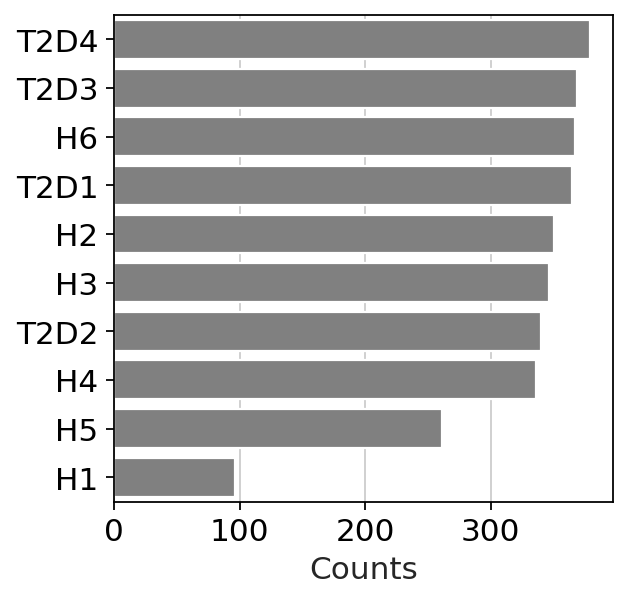

In [20]:
### have a look at cell nrs per sample ### 
temp=bc.tl.count_occurrence(adata,split_condition)
sns.barplot(y=temp.index,x=temp.Counts,color='gray',orient='h')

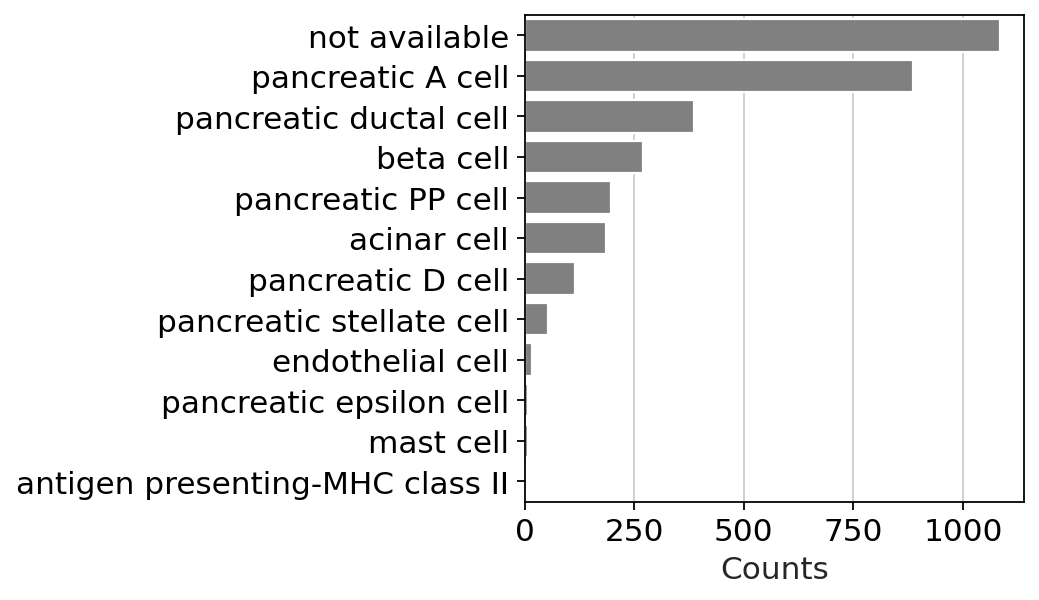

In [21]:

### have a look at cell nrs per cluster ### 
temp=bc.tl.count_occurrence(adata,'Sample Characteristic[inferred cell type]')
sns.barplot(y=temp.index,x=temp.Counts,color='gray',orient='h')

##### Transcript Capture Efficiency
This plot gives you an idea about the sequencing depth and if the sequencing has reached saturation or not.

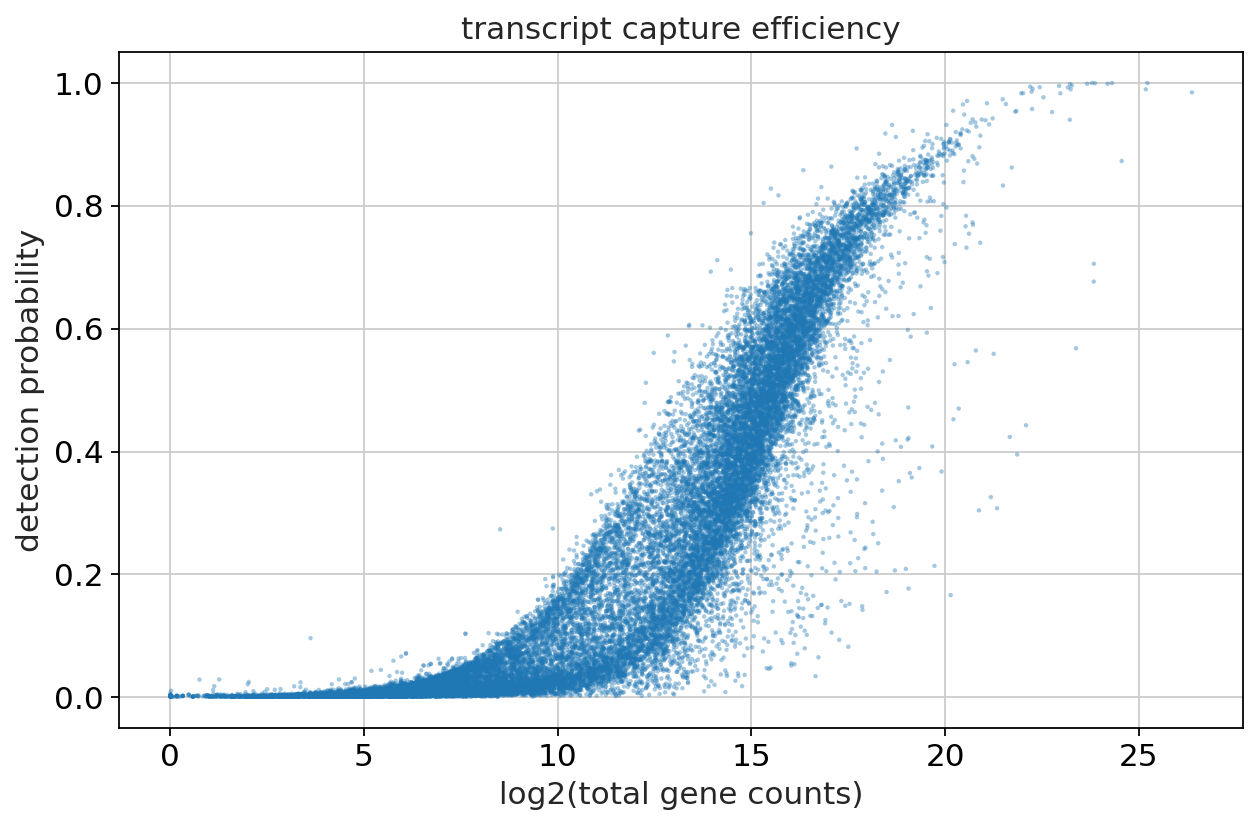

In [22]:
fig, ax = plt.subplots(1)
fig.set_figwidth(8)
fig.set_figheight(5)
fig.tight_layout()

bc.pl.transcript_capture_efficiency(adata,ax=ax)
fig.savefig(os.path.join(results_folder, 'figures/transcriptcaptureefficiency.png'), format='png', bbbox_inches = 'tight') #save figure for QC report

##### Library Size distribution
This plot gives you an idea about the library size distribution in your dataset before processing.

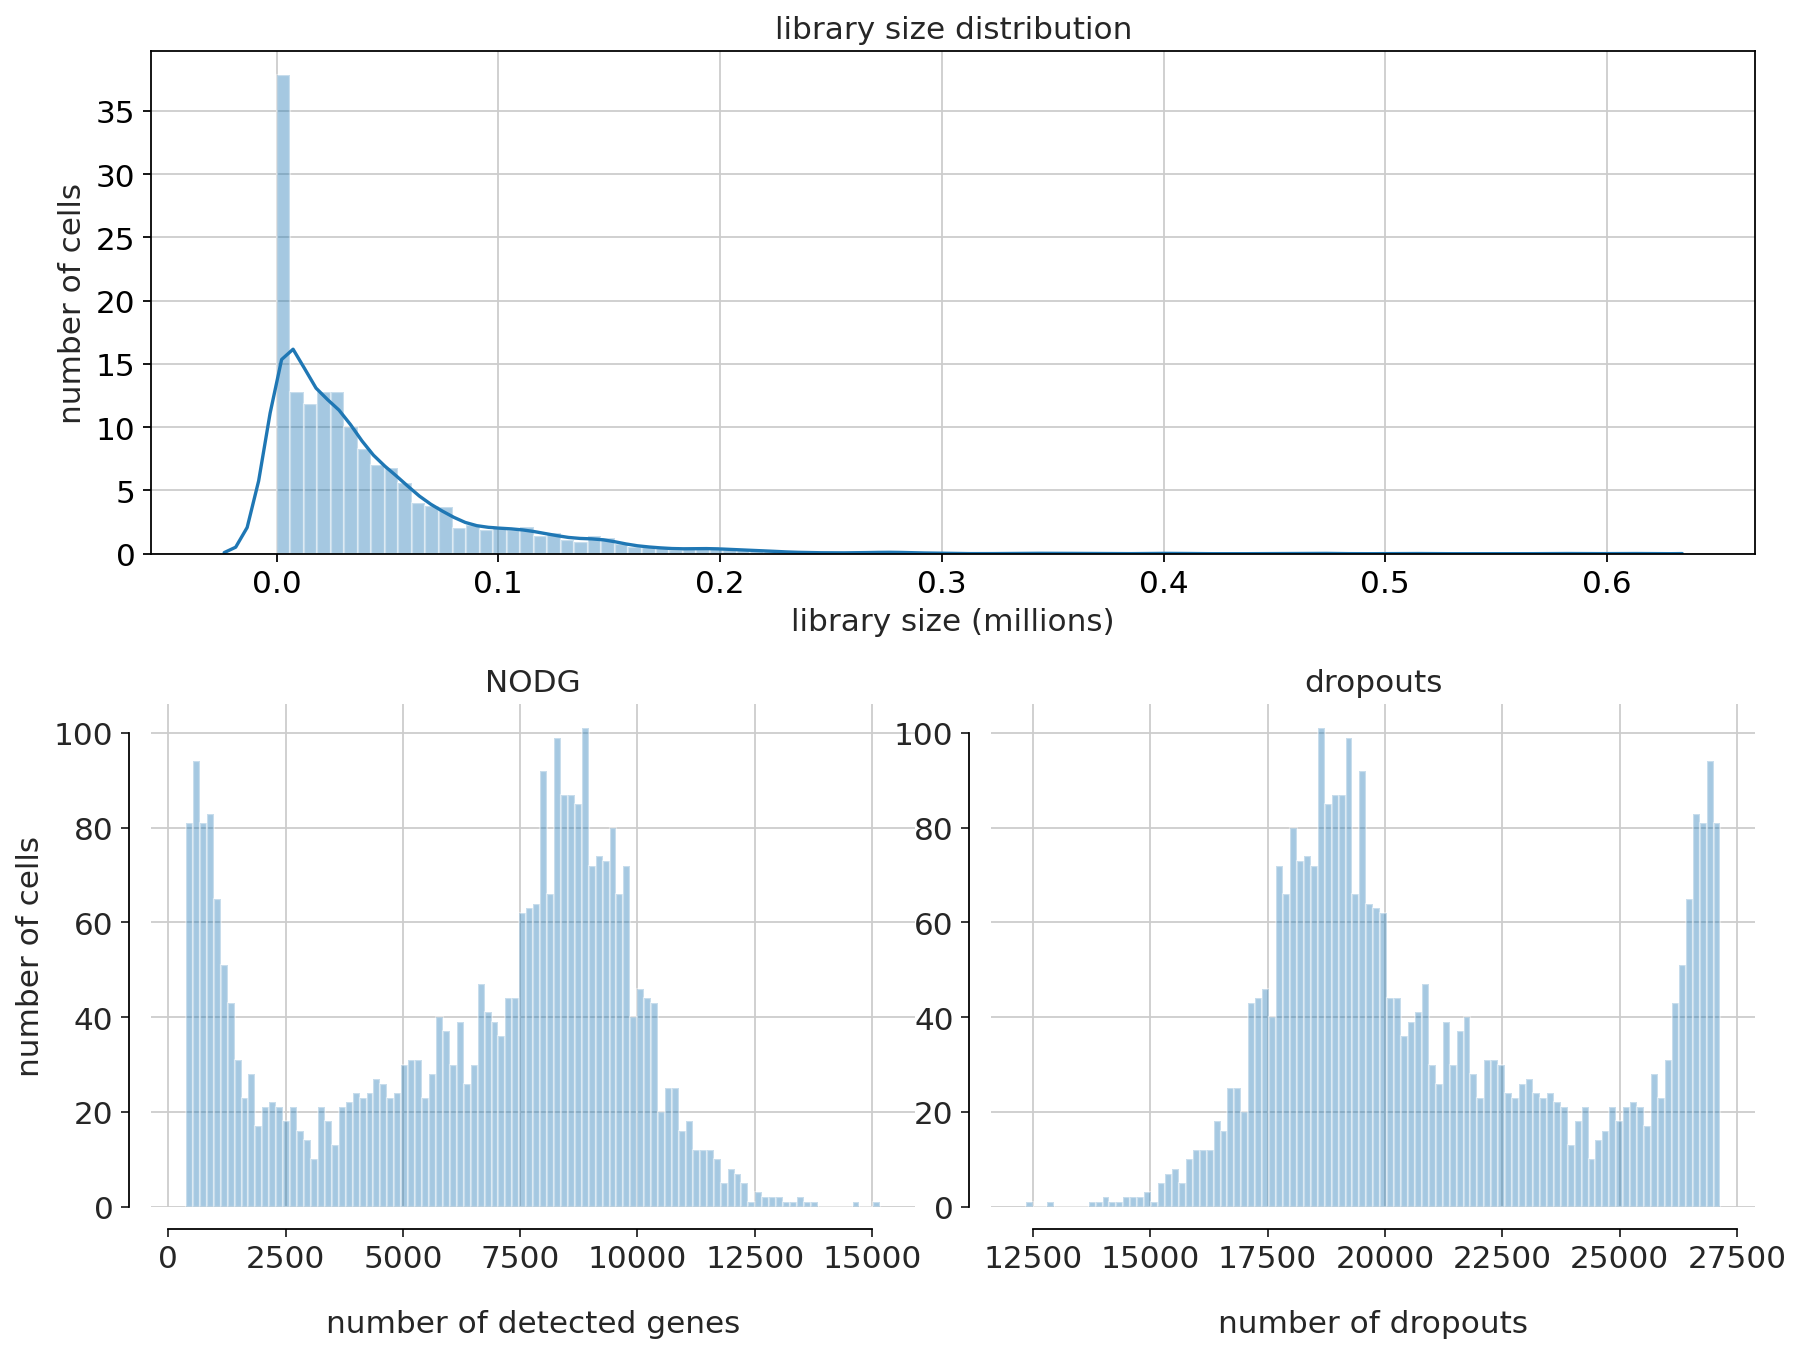

In [23]:
fig = bc.pl.librarysize_overview(adata, bins=100)
fig.savefig(os.path.join(results_folder, 'figures/librarysize.png'), format='png',bbbox_inches = 'tight') #save figure for QC report

In [24]:
adata_unfiltered = adata.copy()

##### Selected Filtering Parameters

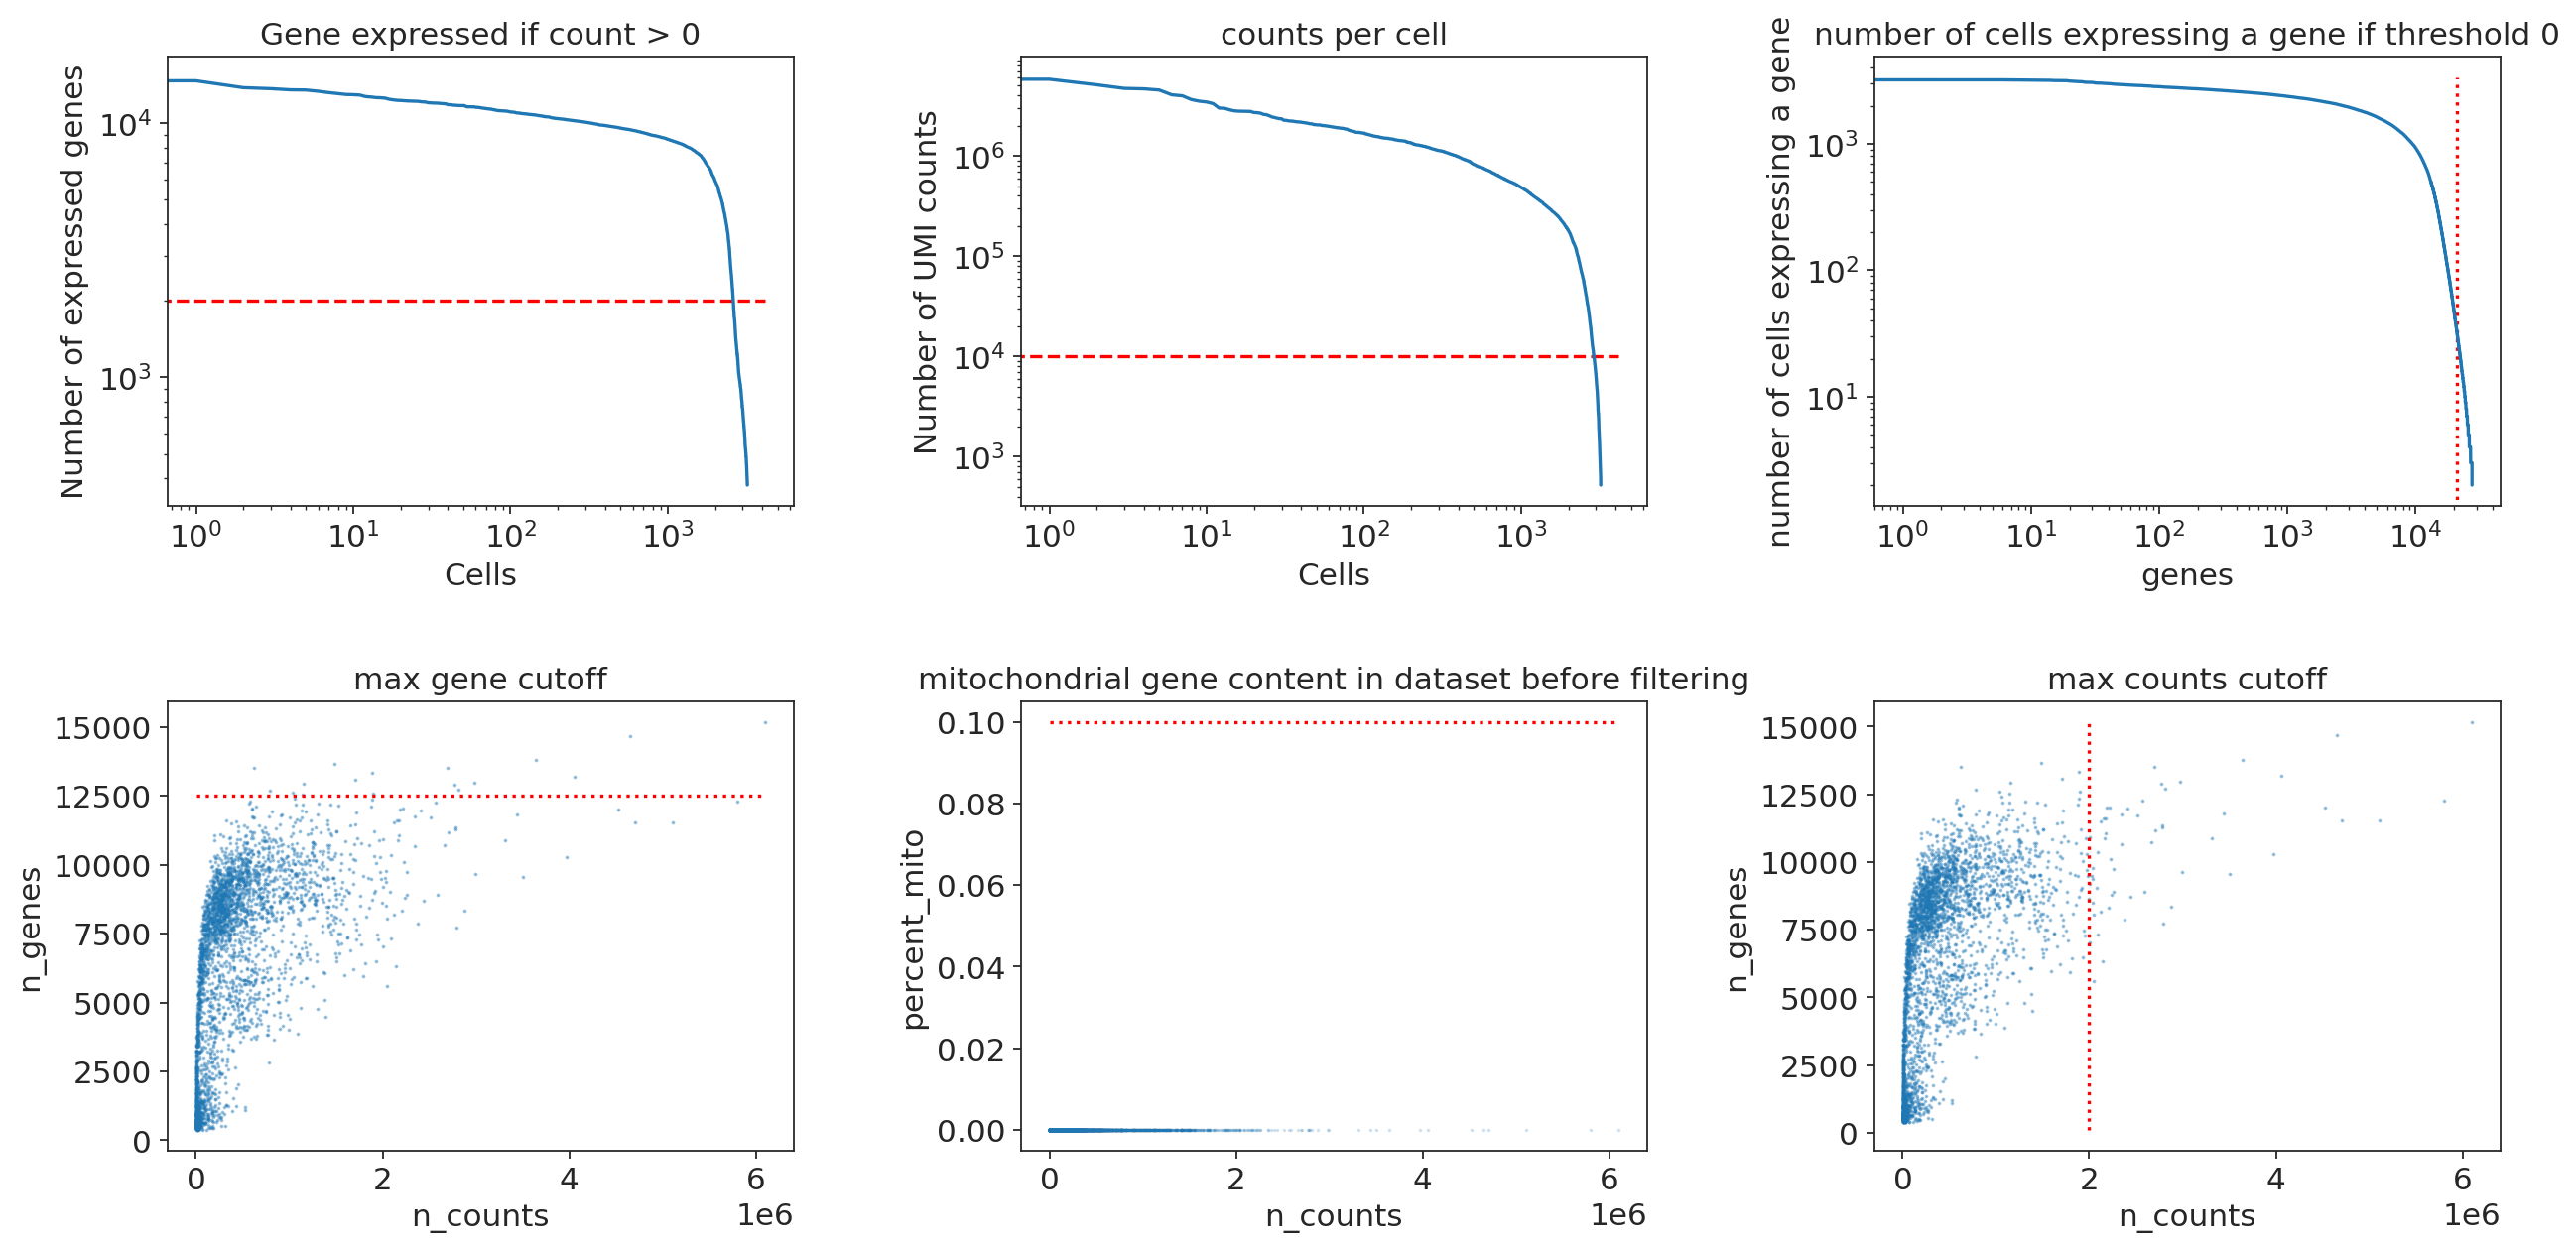

In [28]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(ncols=3, nrows=2)
fig.set_figwidth(17)
fig.set_figheight(9)
fig.tight_layout(pad=4.5)

bc.pl.kp_genes(adata, min_genes=standard_min_genes, ax = ax1)
bc.pl.kp_counts(adata, min_counts=standard_min_counts, ax = ax2)
bc.pl.kp_cells(adata, min_cells=standard_min_cells, ax = ax3)
bc.pl.max_genes(adata, max_genes=standard_n_genes, ax = ax4)
bc.pl.max_mito(adata, max_mito=standard_percent_mito, annotation_type='SYMBOL', species=species, ax = ax5)
bc.pl.max_counts(adata, max_counts=standard_max_counts, ax=ax6)
fig.savefig(os.path.join(results_folder, 'figures/filtering_thresholds.png'), format='png', bbbox_inches = 'tight') #save figure for QC report

... storing 'Sample Characteristic[organism]' as categorical
... storing 'Sample Characteristic Ontology Term[organism]' as categorical
... storing 'Sample Characteristic[individual]' as categorical
... storing 'Sample Characteristic[sex]' as categorical
... storing 'Sample Characteristic Ontology Term[sex]' as categorical
... storing 'Sample Characteristic[age]' as categorical
... storing 'Sample Characteristic[body mass index]' as categorical
... storing 'Sample Characteristic[organism status]' as categorical
... storing 'Sample Characteristic Ontology Term[organism status]' as categorical
... storing 'Sample Characteristic[clinical information]' as categorical
... storing 'Sample Characteristic[organism part]' as categorical
... storing 'Sample Characteristic Ontology Term[organism part]' as categorical
... storing 'Sample Characteristic[cell type]' as categorical
... storing 'Sample Characteristic Ontology Term[cell type]' as categorical
... storing 'Sample Characteristic[disease]'

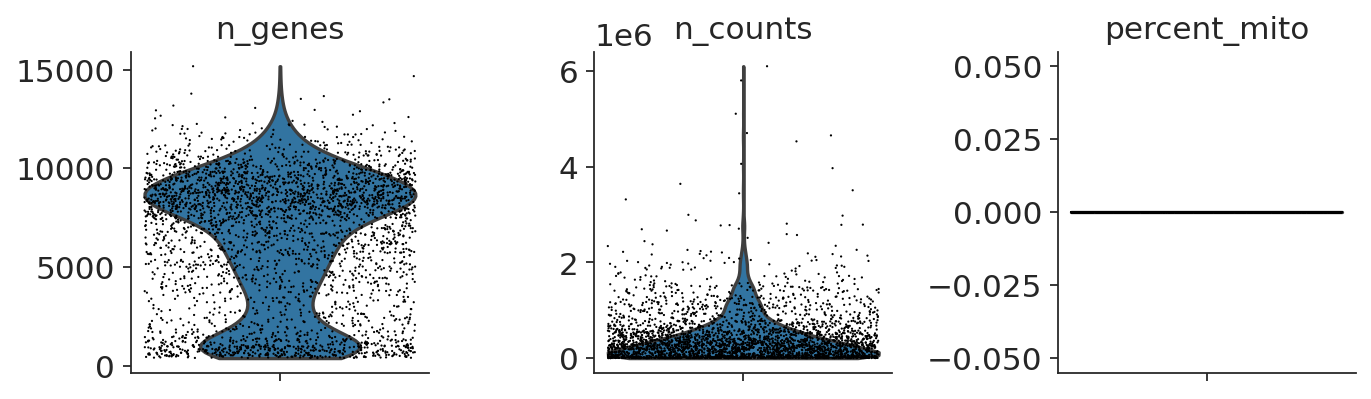

In [29]:
sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'], jitter=0.4, multi_panel=True, save = '.before_filtering.png')

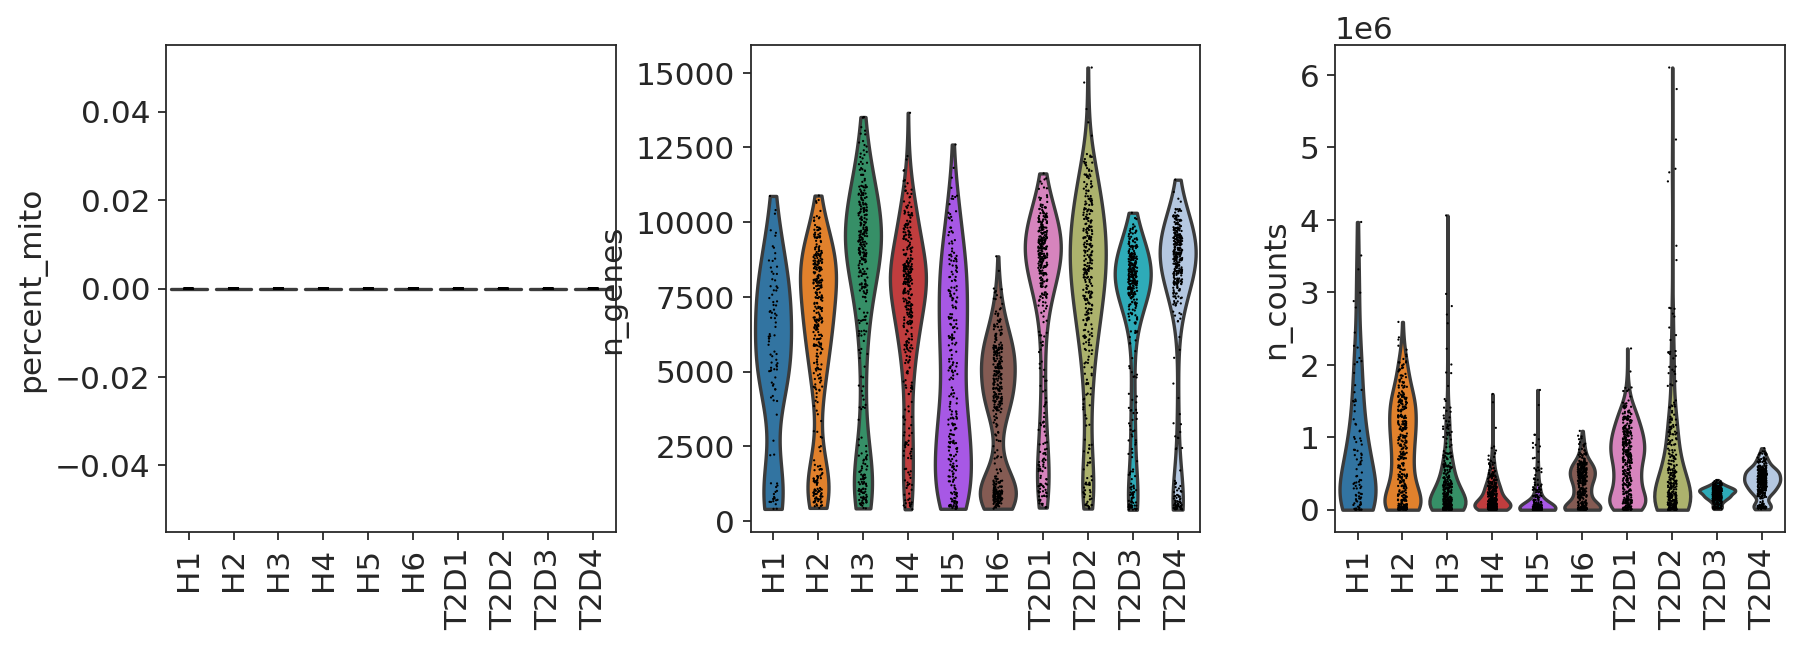

In [30]:
### check mitochondrial reads per sample 
sc.pl.violin(adata, ['percent_mito','n_genes', 'n_counts'],
             groupby=split_condition,jitter=0.1,rotation=90, save = '.before_filtering.split.png')

### First filtering on gene and cell counts

In [31]:
%%capture filtering1
adata = bc.st.filtering_cells_genes_min(adata, standard_min_cells, standard_min_genes, standard_min_counts)

LOG MESSAGE: After filtering for minimum number of cells and minimum number of expressed genes: 2554 cells, 21246 genes
LOG MESSAGE: 	Time for filtering: 0.601s


In [32]:
filtering1.show()

started with  3211  total cells and  27528  total genes
removed 596 cells that did not express at least 2000  genes
removed 61 cells that did not have at least 10000 counts
removed 6282 genes that were not expressed in at least 30 cells
finished with 2554  total cells and 21246 total genes


### Second filtering on mitochondrial genes, and upper limit for gene number ###

In [33]:
%%capture filtering2
adata = bc.st.filtering_mito_genes_max(adata, standard_percent_mito, standard_n_genes, standard_max_counts)

LOG MESSAGE: After filtering for maximum number of expressed genes and max percent mito: 2488 cells, 21246 genes
LOG MESSAGE: 	Time for filtering: 0.381s


In [34]:
filtering2.show()

started with  2554  total cells and  21246  total genes
removed 17 cells that expressed more than 12500 genes
removed 49 cells that had more than 2000000  counts
removed  0  cells that expressed  10.0 percent mitochondrial genes or more
finished with 2488  total cells and 21246 total genes


###  Filtered dataset characteristics

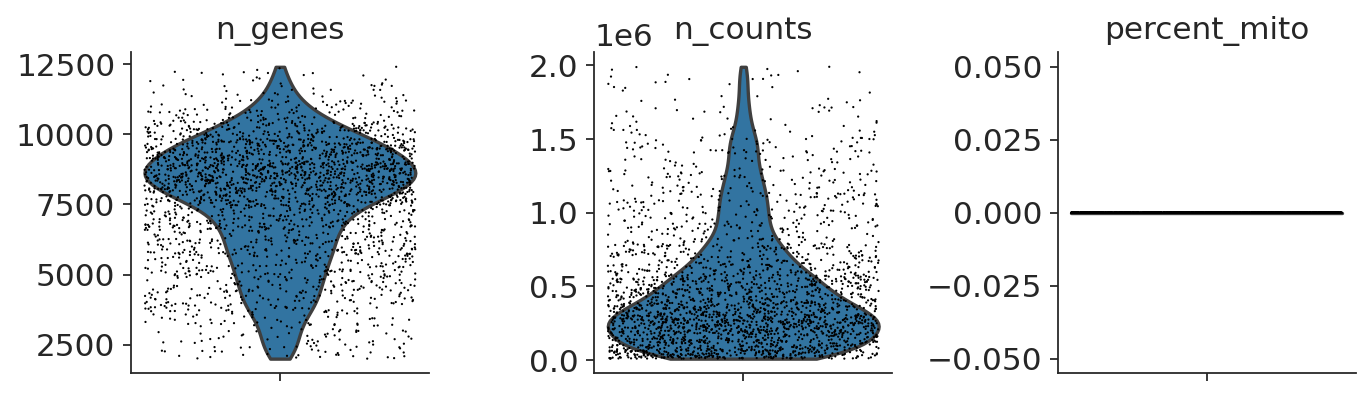

In [35]:
sc.pl.violin(adata, ['n_genes', 'n_counts', 'percent_mito'], jitter=0.4, multi_panel=True, save = '.after_filtering.png')

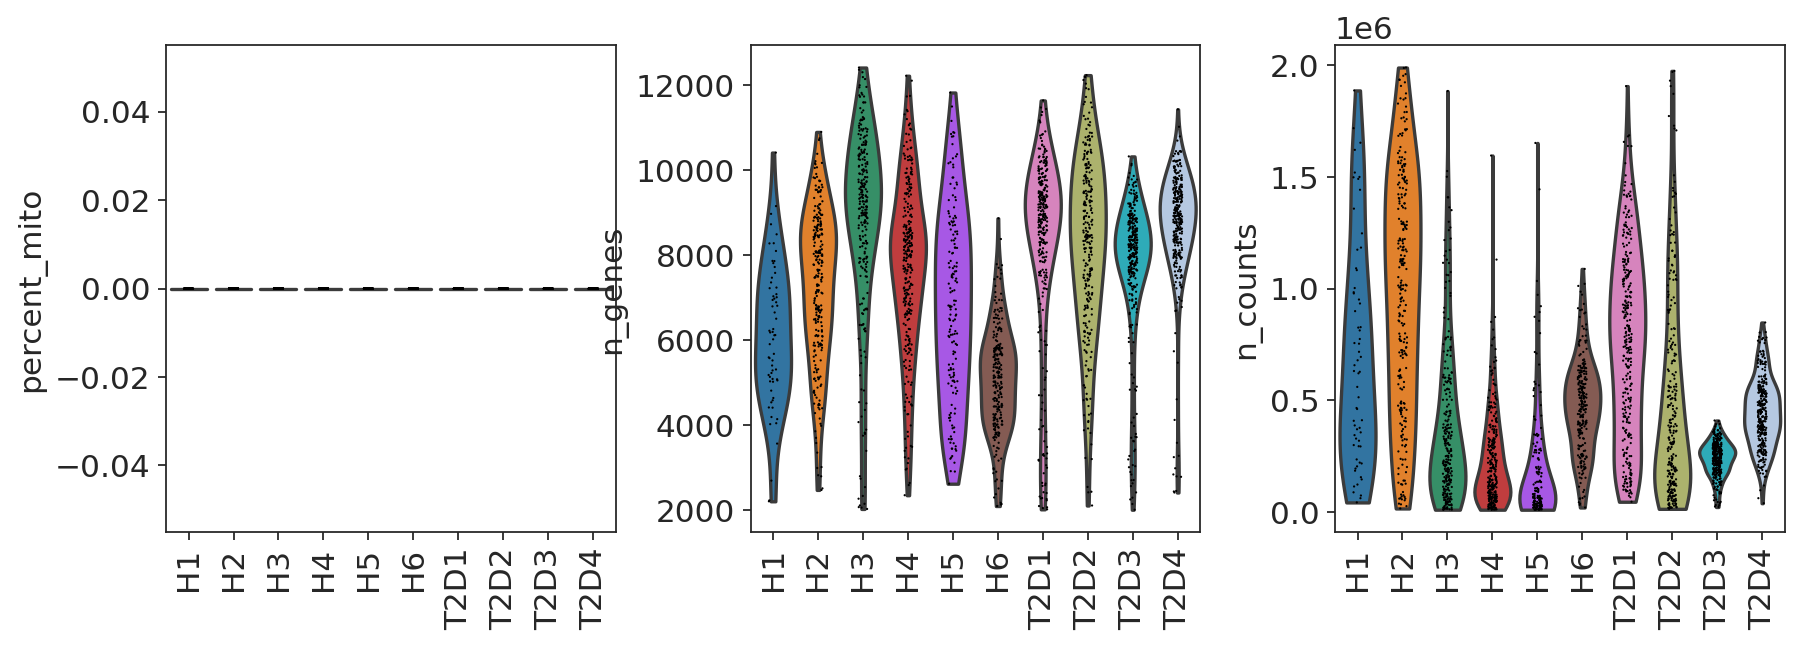

In [36]:
### check mitochondrial reads per sample 
sc.pl.violin(adata, ['percent_mito','n_genes', 'n_counts'], groupby=split_condition,jitter=0.1,rotation=90, save = '.after_filtering.split.png')

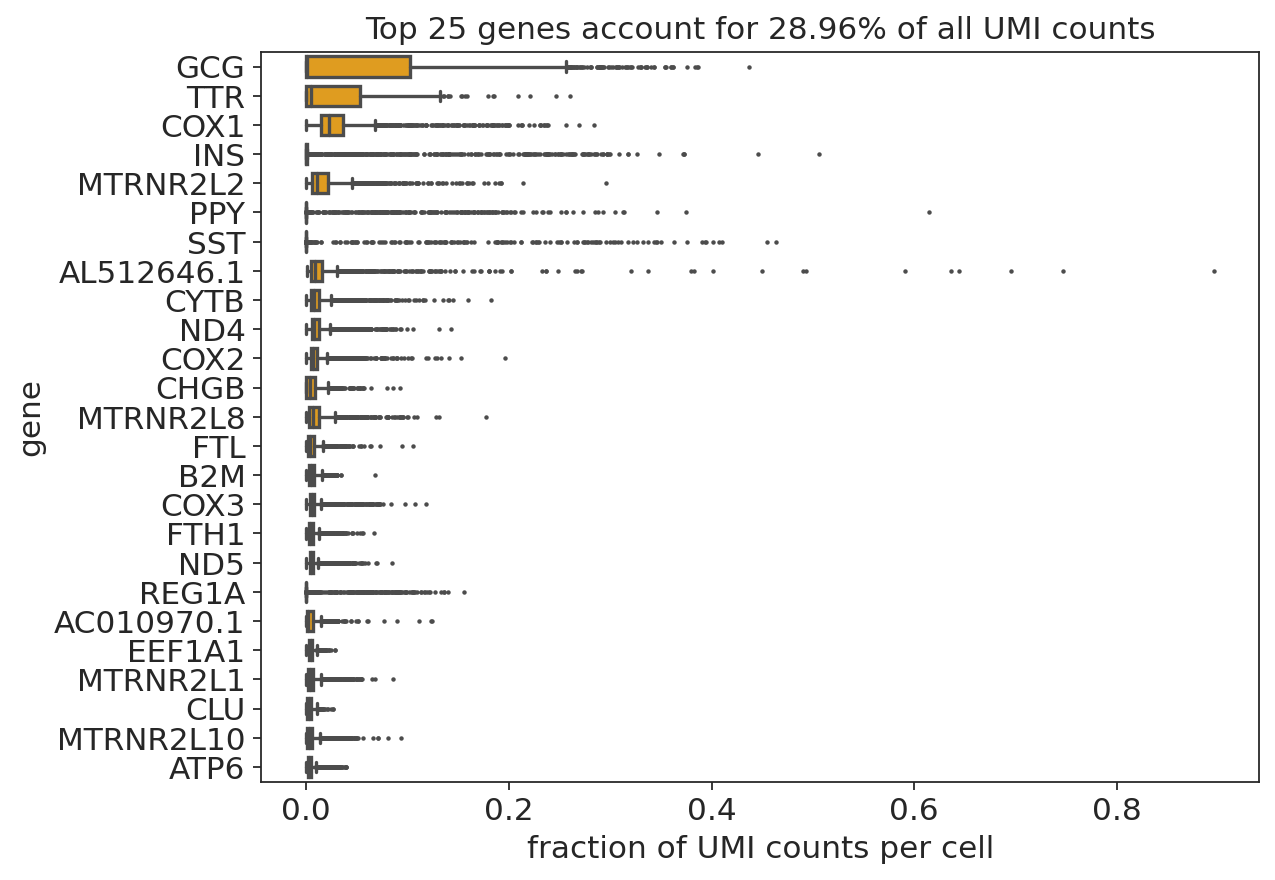

In [37]:
#display the top 25 genes in the dataset
fig, ax = plt.subplots(ncols=1, nrows=1, figsize = (8, 6))
bc.pl.top_genes_counts(adata=adata, top_n=25, ax = ax )
fig.savefig(os.path.join(results_folder, 'figures/top_genes.png'), format='png', bbbox_inches = 'tight') #save figure for QC report

### Per-cell normalization, and output of normalized results ###

In [38]:
adata = bc.st.per_cell_normalize(adata, results_folder)

adata normalized per cell


LOG MESSAGE: Per cell normalization completed successfully.
LOG MESSAGE: 	Time for per-cell normalization: 0.566s


log1p values saved into adata.raw
writing out matrix.mtx ...


LOG MESSAGE: cp10k values exported to file.
LOG MESSAGE: 	Time for cp10k export: 36.761s


adata.X successfully written to matrix.mtx. 
genes successfully written out to genes.tsv
cellbarcodes successfully written out to barcodes.tsv
annotation successfully written out to metadata.tsv


<Figure size 320x320 with 0 Axes>

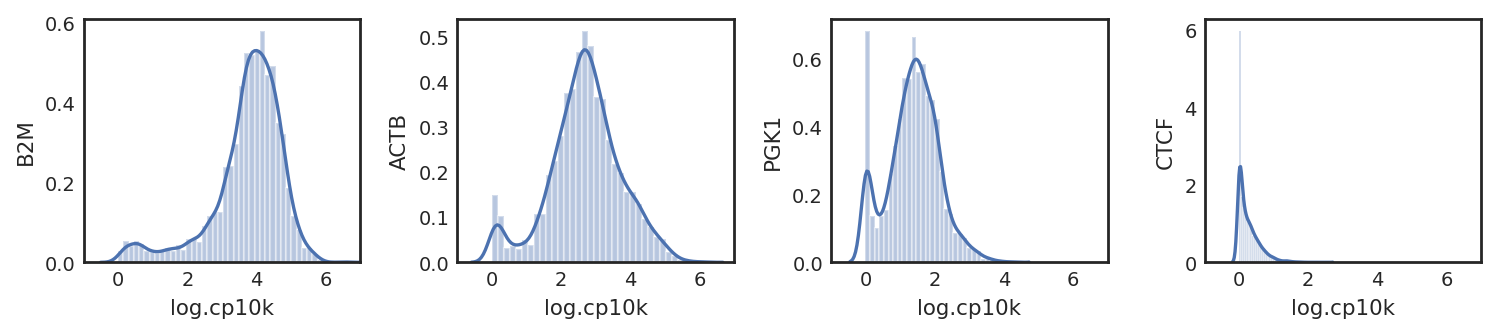

In [39]:
# Further QC: dynamic range of ubi/marker genes
fig = plt.figure()
sns.set(font_scale=0.8)
plt.style.use('seaborn-white')
fig = plt.figure(figsize=(len(dynrange)*2.8,2))
fig.subplots_adjust(hspace=0.2, wspace=0.35)
for i in range(1,len(dynrange)+1):
    ax = fig.add_subplot(1, len(dynrange), i)
    myg=dynrange[i-1]
    try:
        g=sns.distplot(adata.raw[:,myg].X.toarray(), norm_hist=True)
        ax.set(xlabel='log.cp10k',ylabel=myg)
        g.set_xlim(-1, 7)
    except:
        print( myg + ' can not be plotted')
        
        
   


### Feature selection (highly variable genes) for clustering ###

log1p taken of adata


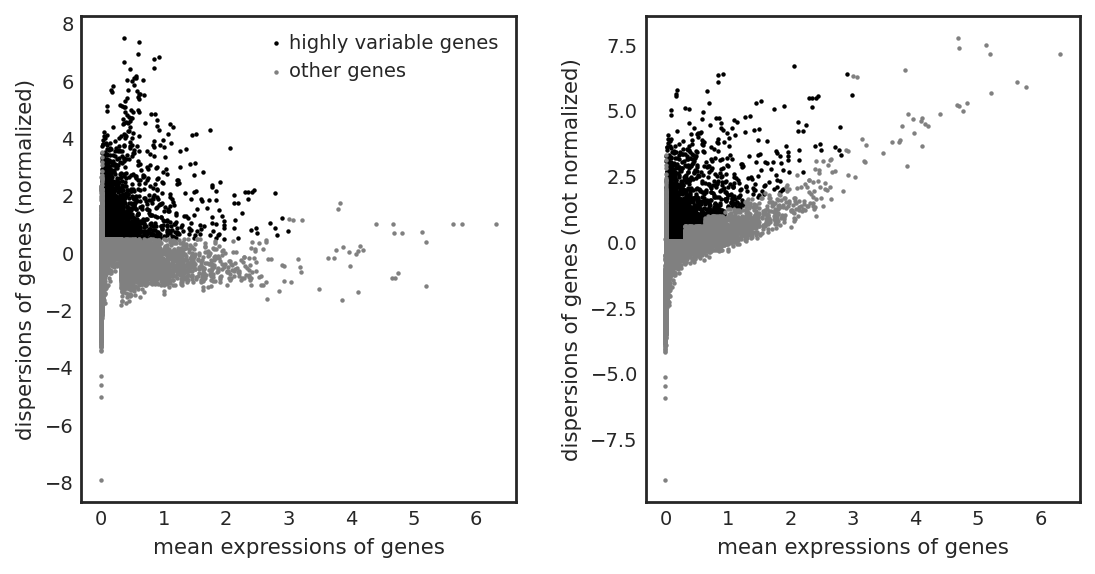

LOG MESSAGE: After feature selection of highly variable genes: 2488 cells, 5040 genes
LOG MESSAGE: 	Time for feature selection: 3.897s


In [40]:
adata = bc.st.highly_variable_genes(adata)

### Regression steps, and output of regressed data ###

In [41]:
adata 

View of AnnData object with n_obs × n_vars = 2488 × 5040 
    obs: 'Sample Characteristic[organism]', 'Sample Characteristic Ontology Term[organism]', 'Sample Characteristic[individual]', 'Sample Characteristic Ontology Term[individual]', 'Sample Characteristic[sex]', 'Sample Characteristic Ontology Term[sex]', 'Sample Characteristic[age]', 'Sample Characteristic Ontology Term[age]', 'Sample Characteristic[body mass index]', 'Sample Characteristic Ontology Term[body mass index]', 'Sample Characteristic[organism status]', 'Sample Characteristic Ontology Term[organism status]', 'Sample Characteristic[clinical information]', 'Sample Characteristic Ontology Term[clinical information]', 'Sample Characteristic[organism part]', 'Sample Characteristic Ontology Term[organism part]', 'Sample Characteristic[cell type]', 'Sample Characteristic Ontology Term[cell type]', 'Sample Characteristic[disease]', 'Sample Characteristic Ontology Term[disease]', 'Sample Characteristic[biosource provider]', 'S

In [42]:
# RMK : AS OF FEB 2020 there is a bug in scanpy regress out if scanpy installed with PIP (see https://github.com/theislab/scanpy/issues/707)
# Before the fix is available, one should coopy the data toprevet it. hence the adata = adata.copy()
adata = adata.copy()
adata = bc.st.regress_out(adata, results_folder)

LOG MESSAGE: Regression steps completed. 'n_counts' and 'percent_mito' regressed out. adata was log-normalized and scaled.
LOG MESSAGE: 	Time for regression steps: 18.252s


'n_counts' and 'percent_mito' regressed out
adata scaled with max_value set to 10


### Batch correction and PCA neighbor analysis and UMAP

The standard workflow uses bbknn as  batch correction method.


Using random_state = 0 for all the following calculations
PCA calculated using svd_solver = 'arpack'. PCA multiplied by -1 to match Seurat output.


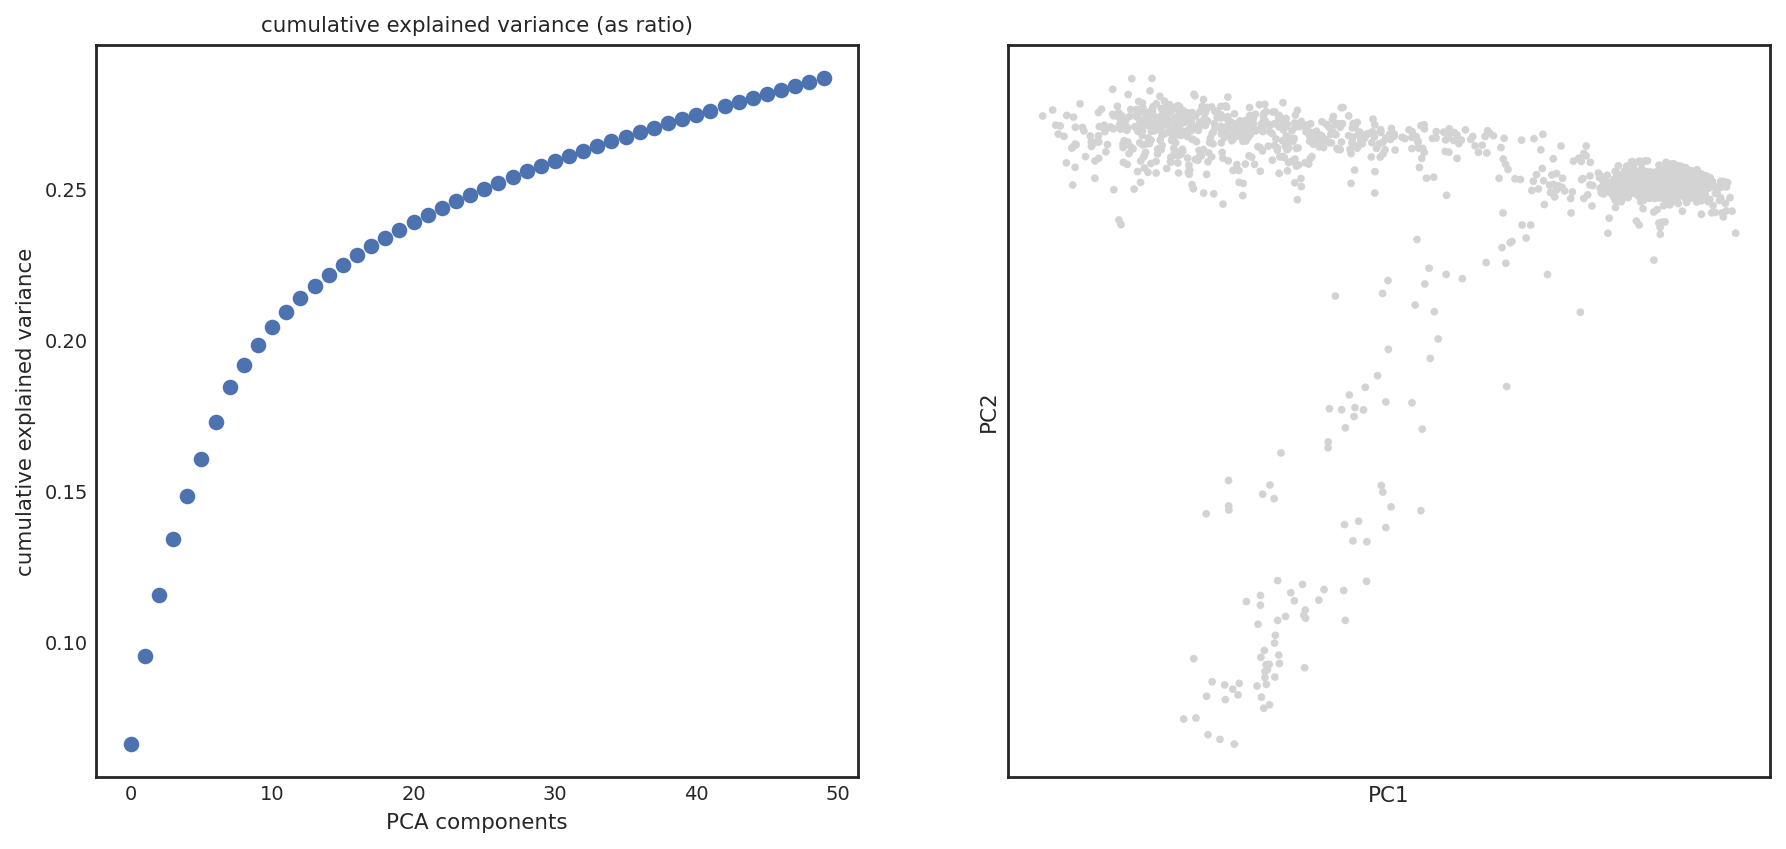

Nearest neighbors calculated with n_neighbors = 10


LOG MESSAGE: Neighborhood analysis completed, and UMAP generated.
LOG MESSAGE: 	 Time for PCA, nearest neighbor calculation and UMAP generation: 10.835s
LOG MESSAGE: Metadata containing 3 PCAs and UMAP coordinates exported successfully to file.
LOG MESSAGE: Time for export: 0.054s


UMAP coordinates calculated.
results successfully written out to 'analysis_metadata.tsv'


In [43]:
if (batch_to_correct != 'None'):
    #save a copy of uncorrected in case we need it for something later
    adata_uncorrected = adata.copy()
    adata.obs['batch'] = adata.obs[batch_to_correct]
    adata = bc.st.pca_neighbors_umap(adata,results_folder, method='bbknn')
else:
    adata = bc.st.pca_neighbors_umap(adata, results_folder)
    

### Clustering ###

leiden clustering performed with a resolution of 1


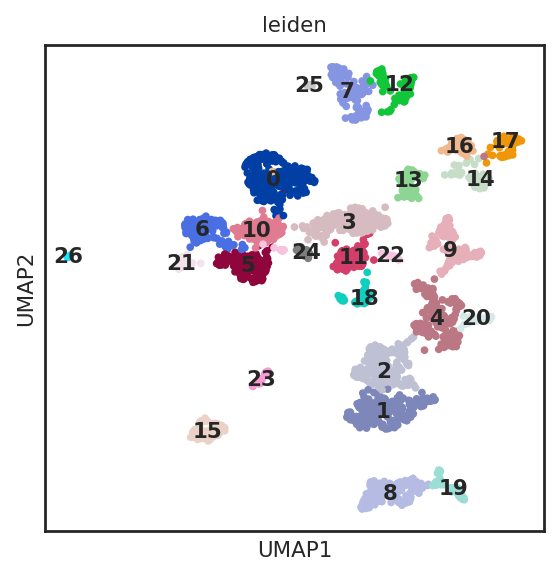

LOG MESSAGE: leidenclustering done. Found 27 clusters.
LOG MESSAGE: 	Time for leiden clustering: 0.6s
LOG MESSAGE: Marker gene detection performed on a per-cluster basis using the method wilcoxon.
LOG MESSAGE: 	Time for marker gene detection: 8.318s


rank genes per cluster calculated using method wilcoxon.
mapping of cells to  leiden exported successfully to cell2labels.tsv
average.gct exported successfully to file
fract_pos.gct exported successfully to file
labelinfo.tsv successfully written out
.//analyzed/standard_workflow_besca2.0/labelings/leiden/WilxRank.gct written out
.//analyzed/standard_workflow_besca2.0/labelings/leiden/WilxRank.pvalues.gct written out


LOG MESSAGE: Cluster level analysis and marker genes exported to file.
LOG MESSAGE: 	Time for export of cluster level analysis: 6.239s


.//analyzed/standard_workflow_besca2.0/labelings/leiden/WilxRank.logFC.gct written out


In [44]:
# leiden clustering is the default 
adata = bc.st.clustering(adata, results_folder)

In [45]:
# everything that was done so far goes to the .h5ad file for later use
adata.write(results_file)
print(results_file)

.//analyzed/standard_workflow_besca2.0/standard_workflow_besca2.0.h5ad


In [46]:
adata.obs_keys

<bound method AnnData.obs_keys of AnnData object with n_obs × n_vars = 2488 × 5040 
    obs: 'Sample Characteristic[organism]', 'Sample Characteristic Ontology Term[organism]', 'Sample Characteristic[individual]', 'Sample Characteristic Ontology Term[individual]', 'Sample Characteristic[sex]', 'Sample Characteristic Ontology Term[sex]', 'Sample Characteristic[age]', 'Sample Characteristic Ontology Term[age]', 'Sample Characteristic[body mass index]', 'Sample Characteristic Ontology Term[body mass index]', 'Sample Characteristic[organism status]', 'Sample Characteristic Ontology Term[organism status]', 'Sample Characteristic[clinical information]', 'Sample Characteristic Ontology Term[clinical information]', 'Sample Characteristic[organism part]', 'Sample Characteristic Ontology Term[organism part]', 'Sample Characteristic[cell type]', 'Sample Characteristic Ontology Term[cell type]', 'Sample Characteristic[disease]', 'Sample Characteristic Ontology Term[disease]', 'Sample Characteristi

LOG MESSAGE: 'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
LOG MESSAGE: 'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
LOG MESSAGE: 'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
LOG MESSAGE: 'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-map

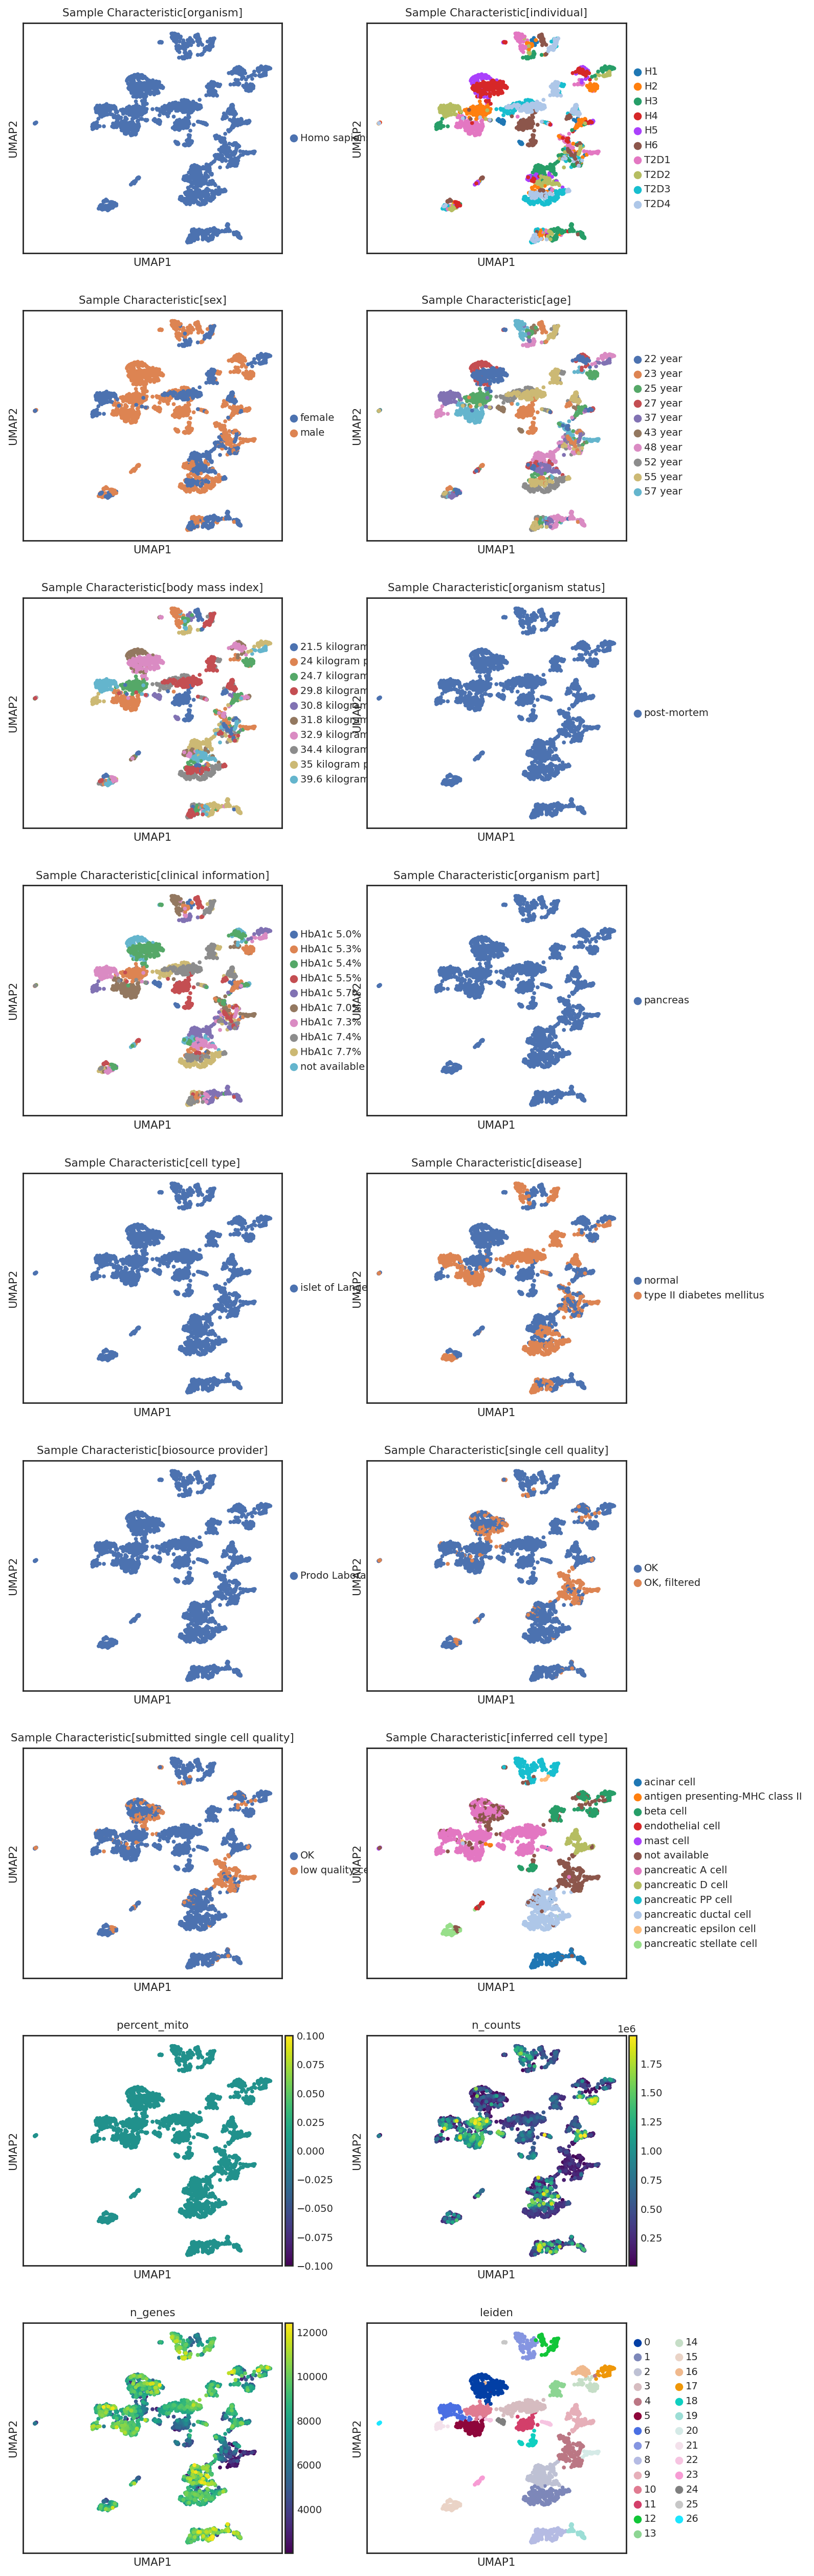

In [47]:
sc.pl.umap( adata, color=['Sample Characteristic[organism]',  'Sample Characteristic[individual]', 
                         'Sample Characteristic[sex]',
                          'Sample Characteristic[age]', 'Sample Characteristic[body mass index]',
                          'Sample Characteristic[organism status]', 
                          'Sample Characteristic[clinical information]', 
                          'Sample Characteristic[organism part]', 
                           'Sample Characteristic[cell type]',  'Sample Characteristic[disease]', 
                         'Sample Characteristic[biosource provider]',  'Sample Characteristic[single cell quality]', 
                        'Sample Characteristic[submitted single cell quality]',
                           'Sample Characteristic[inferred cell type]', 
                        #'Factor Value[disease]', 
                          'percent_mito', 'n_counts', 
                          'n_genes', 'leiden'], color_map = 'viridis', ncols=2)


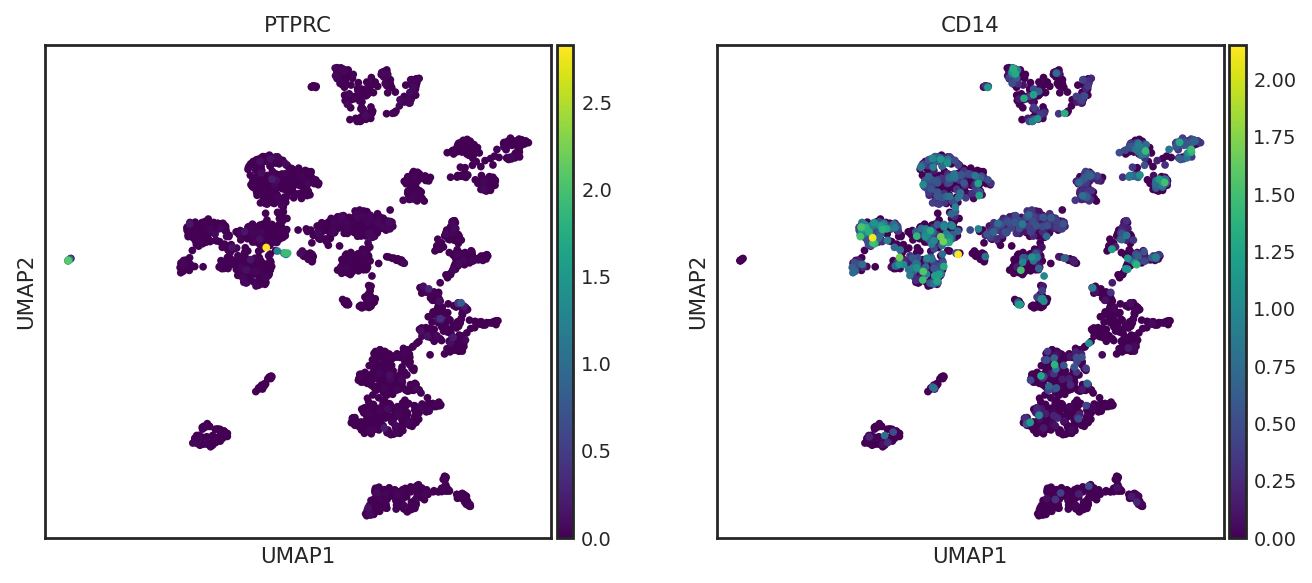

In [48]:
sc.pl.umap( adata, color=['PTPRC', 'CD14'], color_map = 'viridis')

### Additional Labeling ###

(if specified) based on external annotation in "metadata.tsv"  the additional labeling will be exported to file and the fract_pos.gct and average.gct files generated

In [49]:
if (labeling_to_use != 'None'):
    adata = bc.st.additional_labeling(adata, labeling_to_use, labeling_name, labeling_description, labeling_author, results_folder)

### Complete log-file

In [50]:
logging.info('Entire workflow completed.')
logging.info('\tTime for entire workflow: '+str(round(time.time()-start0, 3))+'s')

LOG MESSAGE: Entire workflow completed.
LOG MESSAGE: 	Time for entire workflow: 362.445s


### Write QC Report

In [51]:
bc.st.write_qc(adata_unfiltered = adata_unfiltered, 
                 adata_filtered = adata,
                 version = version, 
                 analysis_name = analysis_name, 
                 standard_min_genes = standard_min_genes, 
                 standard_min_cells = standard_min_cells, 
                 standard_min_counts = standard_min_counts, 
                 standard_percent_mito = standard_percent_mito, 
                 standard_max_counts = standard_max_counts,
                 standard_n_genes = standard_n_genes,
                 filtering_output1 = filtering1,
                 filtering_output2 = filtering2,
                 results_folder = results_folder,
                 css_path = os.path.join(os.path.dirname(bc.__file__),'st', 'style.css'))
logging.info('QC Report generated and saved as .html')

LOG MESSAGE: QC Report generated and saved as .html
